## Paths

In [3]:
dataset_path = "/home/juliamatos/Área de Trabalho/trabalhoCNN/datasets/SimpleSoyNet"
tensorboard_path = "../logs/"
models_path = "../models/SoyNet/"

## Dataloader

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [5]:
# carrega a ResNet do PyTorch
import torch
from torchvision.models import SqueezeNet1_0_Weights, squeezenet1_0


# transformações para a ResNet18 
my_transform = SqueezeNet1_0_Weights.DEFAULT.transforms()


In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


# função para dividir o dataset em treino e teste
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [8]:
import torch
from torchvision.datasets import ImageFolder


# carrega o dataset de imagens com as transformações definidas
data = ImageFolder(root=dataset_path, transform=my_transform)

# divide o dataset em treino e teste
train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 256

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(len(data))
print(len(train_data))
print(len(test_data))

7299
5109
2190


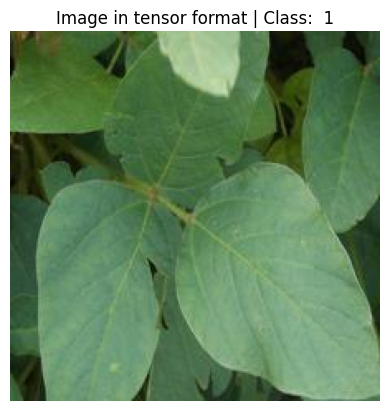

In [9]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

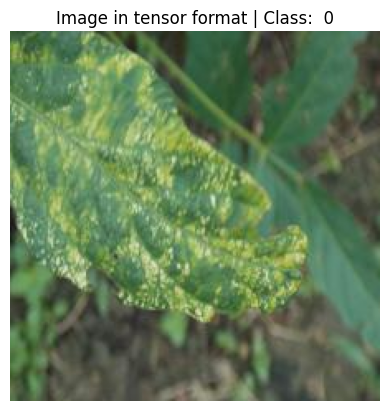

In [10]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

## Train

In [11]:
# função de validação do modelo
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

In [12]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy
def plot_layers(net, writer, epoch):
    # plot da camada fc (fully connected)
    if hasattr(net, "fc"):
        layer = net.fc
        if isinstance(layer, torch.nn.Linear):
            writer.add_histogram('Weight/fc', layer.weight, epoch)
            if layer.bias is not None:
                writer.add_histogram('Bias/fc', layer.bias, epoch)



def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    # otimizador e função de perda
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  
    
    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    

    accuracies = []
    max_accuracy = -1.0  

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            
            train_x = train_x.to(device)
            train_label = train_label.to(device)

        
            predict_y = net( train_x )
            
            # loss
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # backpropagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        dataset = "SoyNet"
        path = f'{models_path}SqueezeNet-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

## Run with ResNet18

In [13]:
# carrega a resnet18 pré-treinada com ImageNet
model = squeezenet1_0(weights=SqueezeNet1_0_Weights.IMAGENET1K_V1)

In [14]:
# verifica as camadas do modelo
for name, param in model.named_parameters():
    print(f"{name}")

features.0.weight
features.0.bias
features.3.squeeze.weight
features.3.squeeze.bias
features.3.expand1x1.weight
features.3.expand1x1.bias
features.3.expand3x3.weight
features.3.expand3x3.bias
features.4.squeeze.weight
features.4.squeeze.bias
features.4.expand1x1.weight
features.4.expand1x1.bias
features.4.expand3x3.weight
features.4.expand3x3.bias
features.5.squeeze.weight
features.5.squeeze.bias
features.5.expand1x1.weight
features.5.expand1x1.bias
features.5.expand3x3.weight
features.5.expand3x3.bias
features.7.squeeze.weight
features.7.squeeze.bias
features.7.expand1x1.weight
features.7.expand1x1.bias
features.7.expand3x3.weight
features.7.expand3x3.bias
features.8.squeeze.weight
features.8.squeeze.bias
features.8.expand1x1.weight
features.8.expand1x1.bias
features.8.expand3x3.weight
features.8.expand3x3.bias
features.9.squeeze.weight
features.9.squeeze.bias
features.9.expand1x1.weight
features.9.expand1x1.bias
features.9.expand3x3.weight
features.9.expand3x3.bias
features.10.squeez

In [15]:
# Congela todos os parâmetros
for param in model.parameters():
    param.requires_grad = False

# Libera os parâmetros da camada final (classificador)
for name, param in model.named_parameters():
    # Na SqueezeNet, a última camada geralmente é chamada 'classifier'
    if 'classifier' in name:
        param.requires_grad = True
        print(f'Descongelando {name}')

# Modifica a última camada para o número de classes
num_classes = 2
# SqueezeNet usa classifier que é um nn.Sequential, onde o último é Conv2d
# Você deve modificar essa última conv2d para ter saída com num_classes canais

import torch.nn as nn
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

# Se estiver usando PyTorch Lightning ou algo semelhante, pode precisar ajustar o forward também

Descongelando classifier.1.weight
Descongelando classifier.1.bias


In [16]:
# verifica as camadas que estão congeladas
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

features.0.weight: Frozen
features.0.bias: Frozen
features.3.squeeze.weight: Frozen
features.3.squeeze.bias: Frozen
features.3.expand1x1.weight: Frozen
features.3.expand1x1.bias: Frozen
features.3.expand3x3.weight: Frozen
features.3.expand3x3.bias: Frozen
features.4.squeeze.weight: Frozen
features.4.squeeze.bias: Frozen
features.4.expand1x1.weight: Frozen
features.4.expand1x1.bias: Frozen
features.4.expand3x3.weight: Frozen
features.4.expand3x3.bias: Frozen
features.5.squeeze.weight: Frozen
features.5.squeeze.bias: Frozen
features.5.expand1x1.weight: Frozen
features.5.expand1x1.bias: Frozen
features.5.expand3x3.weight: Frozen
features.5.expand3x3.bias: Frozen
features.7.squeeze.weight: Frozen
features.7.squeeze.bias: Frozen
features.7.expand1x1.weight: Frozen
features.7.expand1x1.bias: Frozen
features.7.expand3x3.weight: Frozen
features.7.expand3x3.bias: Frozen
features.8.squeeze.weight: Frozen
features.8.squeeze.bias: Frozen
features.8.expand1x1.weight: Frozen
features.8.expand1x1.bia

Running on cuda


Training epochs...:   0%|          | 0/100 [00:00<?, ?it/s]

Training epochs...:   1%|          | 1/100 [00:08<13:45,  8.34s/it]

Saving Best Model with Accuracy:  86.80365296803653
Epoch:   1 | Accuracy : 86.8037%


Training epochs...:   2%|▏         | 2/100 [00:15<12:52,  7.88s/it]

Saving Best Model with Accuracy:  87.35159817351598
Epoch:   2 | Accuracy : 87.3516%


Training epochs...:   3%|▎         | 3/100 [00:23<12:29,  7.73s/it]

Saving Best Model with Accuracy:  88.31050228310502
Epoch:   3 | Accuracy : 88.3105%


Training epochs...:   4%|▍         | 4/100 [00:31<12:17,  7.68s/it]

Saving Best Model with Accuracy:  89.49771689497717
Epoch:   4 | Accuracy : 89.4977%


Training epochs...:   5%|▌         | 5/100 [00:38<12:17,  7.76s/it]

Saving Best Model with Accuracy:  92.14611872146119
Epoch:   5 | Accuracy : 92.1461%


Training epochs...:   6%|▌         | 6/100 [00:46<12:09,  7.77s/it]

Saving Best Model with Accuracy:  92.1917808219178
Epoch:   6 | Accuracy : 92.1918%


Training epochs...:   7%|▋         | 7/100 [00:54<12:00,  7.75s/it]

Saving Best Model with Accuracy:  92.78538812785388
Epoch:   7 | Accuracy : 92.7854%


Training epochs...:   8%|▊         | 8/100 [01:02<11:54,  7.77s/it]

Saving Best Model with Accuracy:  93.42465753424658
Epoch:   8 | Accuracy : 93.4247%


Training epochs...:   9%|▉         | 9/100 [01:10<11:47,  7.78s/it]

Saving Best Model with Accuracy:  93.6986301369863
Epoch:   9 | Accuracy : 93.6986%


Training epochs...:  10%|█         | 10/100 [01:18<11:45,  7.84s/it]

Epoch:  10 | Accuracy : 93.6073%


Training epochs...:  11%|█         | 11/100 [01:25<11:34,  7.80s/it]

Saving Best Model with Accuracy:  93.97260273972603
Epoch:  11 | Accuracy : 93.9726%


Training epochs...:  12%|█▏        | 12/100 [01:33<11:23,  7.77s/it]

Saving Best Model with Accuracy:  94.52054794520548
Epoch:  12 | Accuracy : 94.5205%


Training epochs...:  13%|█▎        | 13/100 [01:41<11:12,  7.73s/it]

Saving Best Model with Accuracy:  94.65753424657534
Epoch:  13 | Accuracy : 94.6575%


Training epochs...:  14%|█▍        | 14/100 [01:49<11:31,  8.04s/it]

Epoch:  14 | Accuracy : 94.5662%


Training epochs...:  15%|█▌        | 15/100 [01:58<11:27,  8.09s/it]

Epoch:  15 | Accuracy : 94.6575%


Training epochs...:  16%|█▌        | 16/100 [02:05<11:16,  8.05s/it]

Saving Best Model with Accuracy:  94.74885844748859
Epoch:  16 | Accuracy : 94.7489%


Training epochs...:  17%|█▋        | 17/100 [02:14<11:08,  8.05s/it]

Epoch:  17 | Accuracy : 94.7489%


Training epochs...:  18%|█▊        | 18/100 [02:21<10:51,  7.94s/it]

Saving Best Model with Accuracy:  94.88584474885845
Epoch:  18 | Accuracy : 94.8858%


Training epochs...:  19%|█▉        | 19/100 [02:29<10:38,  7.88s/it]

Saving Best Model with Accuracy:  94.93150684931507
Epoch:  19 | Accuracy : 94.9315%


Training epochs...:  20%|██        | 20/100 [02:37<10:27,  7.84s/it]

Saving Best Model with Accuracy:  95.25114155251141
Epoch:  20 | Accuracy : 95.2511%


Training epochs...:  21%|██        | 21/100 [02:45<10:20,  7.86s/it]

Epoch:  21 | Accuracy : 95.2055%


Training epochs...:  22%|██▏       | 22/100 [02:53<10:13,  7.87s/it]

Epoch:  22 | Accuracy : 95.2055%


Training epochs...:  23%|██▎       | 23/100 [03:00<09:58,  7.77s/it]

Epoch:  23 | Accuracy : 95.1142%


Training epochs...:  24%|██▍       | 24/100 [03:08<09:45,  7.70s/it]

Epoch:  24 | Accuracy : 95.1142%


Training epochs...:  25%|██▌       | 25/100 [03:16<09:47,  7.84s/it]

Epoch:  25 | Accuracy : 95.1142%


Training epochs...:  26%|██▌       | 26/100 [03:24<09:51,  7.99s/it]

Epoch:  26 | Accuracy : 95.2055%


Training epochs...:  27%|██▋       | 27/100 [03:32<09:40,  7.95s/it]

Epoch:  27 | Accuracy : 95.2055%


Training epochs...:  28%|██▊       | 28/100 [03:39<09:15,  7.71s/it]

Saving Best Model with Accuracy:  95.4337899543379
Epoch:  28 | Accuracy : 95.4338%


Training epochs...:  29%|██▉       | 29/100 [03:46<08:55,  7.54s/it]

Epoch:  29 | Accuracy : 95.4338%


Training epochs...:  30%|███       | 30/100 [03:54<08:50,  7.58s/it]

Epoch:  30 | Accuracy : 95.2055%


Training epochs...:  31%|███       | 31/100 [04:02<08:56,  7.77s/it]

Epoch:  31 | Accuracy : 95.2055%


Training epochs...:  32%|███▏      | 32/100 [04:10<08:50,  7.80s/it]

Saving Best Model with Accuracy:  95.52511415525115
Epoch:  32 | Accuracy : 95.5251%


Training epochs...:  33%|███▎      | 33/100 [04:18<08:46,  7.86s/it]

Epoch:  33 | Accuracy : 95.3425%


Training epochs...:  34%|███▍      | 34/100 [04:26<08:32,  7.77s/it]

Epoch:  34 | Accuracy : 95.3425%


Training epochs...:  35%|███▌      | 35/100 [04:33<08:21,  7.71s/it]

Epoch:  35 | Accuracy : 95.3425%


Training epochs...:  36%|███▌      | 36/100 [04:41<08:11,  7.67s/it]

Saving Best Model with Accuracy:  95.662100456621
Epoch:  36 | Accuracy : 95.6621%


Training epochs...:  37%|███▋      | 37/100 [04:49<08:10,  7.79s/it]

Epoch:  37 | Accuracy : 95.5708%


Training epochs...:  38%|███▊      | 38/100 [04:57<08:02,  7.79s/it]

Saving Best Model with Accuracy:  95.75342465753425
Epoch:  38 | Accuracy : 95.7534%


Training epochs...:  39%|███▉      | 39/100 [05:04<07:53,  7.76s/it]

Epoch:  39 | Accuracy : 95.6621%


Training epochs...:  40%|████      | 40/100 [05:12<07:46,  7.77s/it]

Saving Best Model with Accuracy:  95.79908675799086
Epoch:  40 | Accuracy : 95.7991%


Training epochs...:  41%|████      | 41/100 [05:20<07:35,  7.73s/it]

Epoch:  41 | Accuracy : 95.6621%


Training epochs...:  42%|████▏     | 42/100 [05:28<07:42,  7.97s/it]

Epoch:  42 | Accuracy : 95.6164%


Training epochs...:  43%|████▎     | 43/100 [05:36<07:29,  7.89s/it]

Epoch:  43 | Accuracy : 95.6621%


Training epochs...:  44%|████▍     | 44/100 [05:44<07:18,  7.82s/it]

Saving Best Model with Accuracy:  95.89041095890411
Epoch:  44 | Accuracy : 95.8904%


Training epochs...:  45%|████▌     | 45/100 [05:51<07:06,  7.76s/it]

Epoch:  45 | Accuracy : 95.7534%


Training epochs...:  46%|████▌     | 46/100 [05:59<06:56,  7.72s/it]

Epoch:  46 | Accuracy : 95.6621%


Training epochs...:  47%|████▋     | 47/100 [06:06<06:47,  7.68s/it]

Epoch:  47 | Accuracy : 95.7534%


Training epochs...:  48%|████▊     | 48/100 [06:14<06:38,  7.66s/it]

Epoch:  48 | Accuracy : 95.5708%


Training epochs...:  49%|████▉     | 49/100 [06:22<06:30,  7.66s/it]

Epoch:  49 | Accuracy : 95.8904%


Training epochs...:  50%|█████     | 50/100 [06:30<06:32,  7.85s/it]

Epoch:  50 | Accuracy : 95.8904%


Training epochs...:  51%|█████     | 51/100 [06:38<06:24,  7.85s/it]

Epoch:  51 | Accuracy : 95.8904%


Training epochs...:  52%|█████▏    | 52/100 [06:46<06:14,  7.81s/it]

Epoch:  52 | Accuracy : 95.7991%


Training epochs...:  53%|█████▎    | 53/100 [06:53<06:06,  7.79s/it]

Epoch:  53 | Accuracy : 95.7991%


Training epochs...:  54%|█████▍    | 54/100 [07:01<05:58,  7.79s/it]

Epoch:  54 | Accuracy : 95.7078%


Training epochs...:  55%|█████▌    | 55/100 [07:09<05:47,  7.72s/it]

Epoch:  55 | Accuracy : 95.7078%


Training epochs...:  56%|█████▌    | 56/100 [07:17<05:41,  7.77s/it]

Epoch:  56 | Accuracy : 95.7991%


Training epochs...:  57%|█████▋    | 57/100 [07:24<05:34,  7.79s/it]

Epoch:  57 | Accuracy : 95.7991%


Training epochs...:  58%|█████▊    | 58/100 [07:32<05:26,  7.78s/it]

Epoch:  58 | Accuracy : 95.7078%


Training epochs...:  59%|█████▉    | 59/100 [07:40<05:18,  7.78s/it]

Epoch:  59 | Accuracy : 95.7991%


Training epochs...:  60%|██████    | 60/100 [07:48<05:09,  7.74s/it]

Epoch:  60 | Accuracy : 95.6164%


Training epochs...:  61%|██████    | 61/100 [07:55<05:01,  7.73s/it]

Epoch:  61 | Accuracy : 95.7534%


Training epochs...:  62%|██████▏   | 62/100 [08:03<04:53,  7.71s/it]

Epoch:  62 | Accuracy : 95.7534%


Training epochs...:  63%|██████▎   | 63/100 [08:11<04:44,  7.69s/it]

Epoch:  63 | Accuracy : 95.7534%


Training epochs...:  64%|██████▍   | 64/100 [08:18<04:37,  7.69s/it]

Epoch:  64 | Accuracy : 95.7534%


Training epochs...:  65%|██████▌   | 65/100 [08:26<04:30,  7.74s/it]

Epoch:  65 | Accuracy : 95.7534%


Training epochs...:  66%|██████▌   | 66/100 [08:34<04:22,  7.72s/it]

Epoch:  66 | Accuracy : 95.6164%


Training epochs...:  67%|██████▋   | 67/100 [08:42<04:15,  7.74s/it]

Epoch:  67 | Accuracy : 95.7991%


Training epochs...:  68%|██████▊   | 68/100 [08:49<04:07,  7.73s/it]

Epoch:  68 | Accuracy : 95.6164%


Training epochs...:  69%|██████▉   | 69/100 [08:57<04:04,  7.87s/it]

Epoch:  69 | Accuracy : 95.7534%


Training epochs...:  70%|███████   | 70/100 [09:05<03:57,  7.91s/it]

Epoch:  70 | Accuracy : 95.6164%


Training epochs...:  71%|███████   | 71/100 [09:13<03:50,  7.93s/it]

Epoch:  71 | Accuracy : 95.7991%


Training epochs...:  72%|███████▏  | 72/100 [09:21<03:40,  7.87s/it]

Epoch:  72 | Accuracy : 95.6164%


Training epochs...:  73%|███████▎  | 73/100 [09:29<03:34,  7.94s/it]

Saving Best Model with Accuracy:  95.93607305936074
Epoch:  73 | Accuracy : 95.9361%


Training epochs...:  74%|███████▍  | 74/100 [09:37<03:23,  7.84s/it]

Epoch:  74 | Accuracy : 95.7991%


Training epochs...:  75%|███████▌  | 75/100 [09:45<03:18,  7.95s/it]

Epoch:  75 | Accuracy : 95.7991%


Training epochs...:  76%|███████▌  | 76/100 [09:53<03:08,  7.85s/it]

Epoch:  76 | Accuracy : 95.7991%


Training epochs...:  77%|███████▋  | 77/100 [10:01<03:06,  8.09s/it]

Epoch:  77 | Accuracy : 95.7991%


Training epochs...:  78%|███████▊  | 78/100 [10:09<02:55,  7.99s/it]

Epoch:  78 | Accuracy : 95.9361%


Training epochs...:  79%|███████▉  | 79/100 [10:17<02:47,  7.99s/it]

Epoch:  79 | Accuracy : 95.7991%


Training epochs...:  80%|████████  | 80/100 [10:25<02:37,  7.88s/it]

Epoch:  80 | Accuracy : 95.9361%


Training epochs...:  81%|████████  | 81/100 [10:33<02:29,  7.85s/it]

Saving Best Model with Accuracy:  95.98173515981735
Epoch:  81 | Accuracy : 95.9817%


Training epochs...:  82%|████████▏ | 82/100 [10:40<02:20,  7.78s/it]

Epoch:  82 | Accuracy : 95.6621%


Training epochs...:  83%|████████▎ | 83/100 [10:48<02:11,  7.74s/it]

Epoch:  83 | Accuracy : 95.9817%


Training epochs...:  84%|████████▍ | 84/100 [10:55<02:03,  7.73s/it]

Epoch:  84 | Accuracy : 95.9817%


Training epochs...:  85%|████████▌ | 85/100 [11:04<01:57,  7.83s/it]

Epoch:  85 | Accuracy : 95.9817%


Training epochs...:  86%|████████▌ | 86/100 [11:12<01:50,  7.90s/it]

Saving Best Model with Accuracy:  96.21004566210046
Epoch:  86 | Accuracy : 96.2100%


Training epochs...:  87%|████████▋ | 87/100 [11:19<01:41,  7.85s/it]

Epoch:  87 | Accuracy : 96.2100%


Training epochs...:  88%|████████▊ | 88/100 [11:28<01:35,  7.97s/it]

Epoch:  88 | Accuracy : 95.8904%


Training epochs...:  89%|████████▉ | 89/100 [11:36<01:29,  8.14s/it]

Epoch:  89 | Accuracy : 95.8904%


Training epochs...:  90%|█████████ | 90/100 [11:45<01:23,  8.36s/it]

Epoch:  90 | Accuracy : 95.8904%


Training epochs...:  91%|█████████ | 91/100 [11:53<01:15,  8.35s/it]

Epoch:  91 | Accuracy : 96.0731%


Training epochs...:  92%|█████████▏| 92/100 [12:01<01:05,  8.20s/it]

Epoch:  92 | Accuracy : 96.0731%


Training epochs...:  93%|█████████▎| 93/100 [12:10<00:58,  8.29s/it]

Epoch:  93 | Accuracy : 95.8904%


Training epochs...:  94%|█████████▍| 94/100 [12:17<00:47,  7.96s/it]

Epoch:  94 | Accuracy : 96.2100%


Training epochs...:  95%|█████████▌| 95/100 [12:24<00:38,  7.71s/it]

Epoch:  95 | Accuracy : 95.8904%


Training epochs...:  96%|█████████▌| 96/100 [12:32<00:31,  7.88s/it]

Epoch:  96 | Accuracy : 96.2100%


Training epochs...:  97%|█████████▋| 97/100 [12:39<00:22,  7.66s/it]

Epoch:  97 | Accuracy : 95.9361%


Training epochs...:  98%|█████████▊| 98/100 [12:47<00:15,  7.53s/it]

Epoch:  98 | Accuracy : 95.8904%


Training epochs...:  99%|█████████▉| 99/100 [12:54<00:07,  7.43s/it]

Epoch:  99 | Accuracy : 96.0731%


Training epochs...: 100%|██████████| 100/100 [13:01<00:00,  7.81s/it]

Epoch: 100 | Accuracy : 96.2100%
Model saved in: ../models/SoyNet/SqueezeNet-SoyNet-96.21.pkl


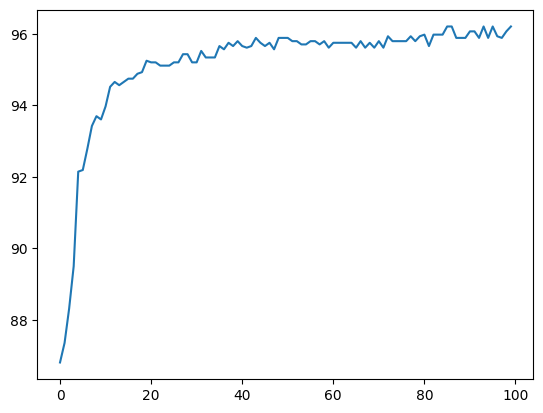

In [17]:
import torch
torch.cuda.empty_cache()

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = model.to(my_device)

epochs = 100
lr = 1e-3
dataset = 'SoyNet'
prefix = 'SqueezeNet-FT-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

# treina o modelo
net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

In [ ]:
import numpy as np
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    my_transform = SqueezeNet1_0_Weights.DEFAULT.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = ["Disease", "Healthy"]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
